In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os
from PIL import Image

%pip install scikit-image -q
%pip install scikit-learn -q
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

#scipy 
%pip install scipy -q
import scipy as scipy

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

from utils import load_data

# FILL IN CODE HERE #
IMAGE_PATH = '/Users/npovejsil/Downloads/CNN_images/' # replace with your path
LABEL_PATH = '//Users/npovejsil/Downloads/CNN_labels/' # replace with your path

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


2024-04-13 19:58:43.380702: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Load Data

In [2]:
#Check file paths are correct
def count_files_in_directory(directory):
    # Check if the directory exists
    if not os.path.exists(directory):
        print("Directory '{}' does not exist.".format(directory))
        return -1

    # Initialize a counter for files
    file_count = 0

    # Iterate over the files in the directory
    for root, dirs, files in os.walk(directory):
        file_count += len(files)

    return file_count

# Example usage:
directory_path = "/Users/npovejsil/Downloads/MIDS/wildfire_folder/train"
file_count = count_files_in_directory(directory_path)
if file_count >= 0:
    print("Number of files in directory '{}': {}".format(directory_path, file_count))

Number of files in directory '/Users/npovejsil/Downloads/MIDS/wildfire_folder/train': 30251


In [3]:
test_path= '/Users/npovejsil/Downloads/MIDS/wildfire_folder/test'
train_path = '/Users/npovejsil/Downloads/MIDS/wildfire_folder/train'
val_path = '/Users/npovejsil/Downloads/MIDS/wildfire_folder/valid'

In [4]:
%%time

X_train, y_train = load_data(train_path)
print("Shape of training images ", X_train.shape)
print("Shape of training labels ", y_train.shape)

X_val, y_val = load_data(val_path)
print("Shape of validation images ", X_val.shape)
print("Shape of validation labels ", y_val.shape)

X_test, y_test = load_data(test_path)
print("Shape of test images ", X_test.shape)
print("Shape of test labels ", y_test.shape)


1 images failed to load.
Shape of training images  (30249, 50, 50, 3)
Shape of training labels  (30249,)
2 images failed to load.
Shape of validation images  (6300, 50, 50, 3)
Shape of validation labels  (6300,)
1 images failed to load.
Shape of test images  (6299, 50, 50, 3)
Shape of test labels  (6299,)
CPU times: user 7min 42s, sys: 20 s, total: 8min 2s
Wall time: 11min 9s


In [5]:
# The labels need to be converted to integers from strings
y_train = np.where(y_train == 'wildfire', 1, 0)
y_val = np.where(y_val == 'wildfire', 1, 0)
y_test = np.where(y_test == 'wildfire', 1, 0)

In [6]:
# # this function plots images in the form of a grid with 1 row and 10 columns 
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10, figsize = (20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img/255)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

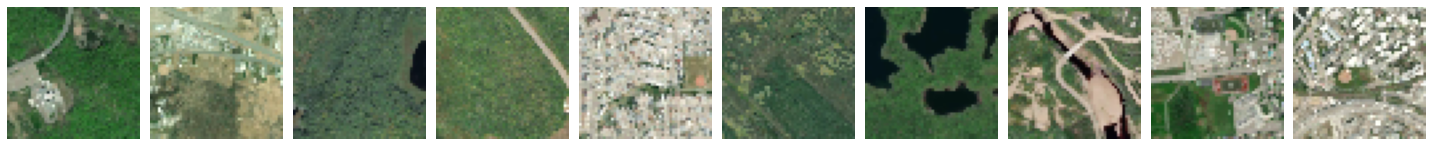

In [57]:
random_samples_indices = np.random.choice(len(X_train), size=10, replace=False)
random_samples = X_train[random_samples_indices]
plotImages(random_samples)

# Data Preprocessing

(array([114.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 142.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

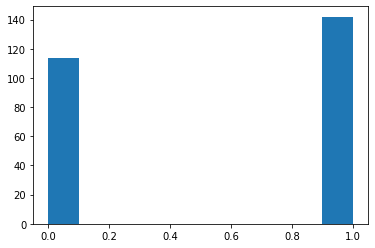

In [9]:
# plt.hist(labels)

# Building the Models

# 1. CNN

In [8]:

tf.keras.backend.clear_session()

model = tf.keras.Sequential()

# add first convolution layer to the model
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))

# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))

# add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), 
    name='pool_2'))

# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1',
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits
# note that passing activation = "sigmoid" will return class membership probabilities but
# in TensorFlow logits are preferred for numerical stability
# set units=1 to get a single output unit (remember it's a binary classification problem)

model.add(tf.keras.layers.Dense(
    units=1,  # Change units to 1 for binary classification
    name='fc_2',
    activation='sigmoid'  # Use sigmoid activation for binary classification
))

# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 50, 50, 3))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 50, 50, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 25, 25, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 1024)           │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,492,929 (36.21 MB)

 Trainable params: 9,492,929 (36.21 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), #set from_ligits=True if our last layer does not apply sigmoid
              metrics=['accuracy'])

In [10]:

# Fit the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_val, y_val)
)

Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 763s 804ms/step - accuracy: 0.8031 - loss: 8.4811 - val_accuracy: 0.9013 - val_loss: 0.2575
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 3536s 4s/step - accuracy: 0.8834 - loss: 0.2846 - val_accuracy: 0.8817 - val_loss: 0.2904
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 3893s 4s/step - accuracy: 0.8930 - loss: 0.2646 - val_accuracy: 0.8913 - val_loss: 0.2642
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 5477s 6s/step - accuracy: 0.8934 - loss: 0.2654 - val_accuracy: 0.8944 - val_loss: 0.2626
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 1119s 1s/step - accuracy: 0.8961 - loss: 0.2566 - val_accuracy: 0.9065 - val_loss: 0.2441
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 315s 333ms/step - accuracy: 0.9031 - loss: 0.2462 - val_accuracy: 0.9102 - val_loss: 0.2374
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 284s 301ms/step - accuracy: 0.8988 - loss: 0.2520 - val_accuracy: 0.9008 - val_loss: 0.2561
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 290s 267ms/step - accuracy: 0.8871 - loss: 0

In [20]:
from sklearn import metrics
from sklearn.metrics import fbeta_score
cnn_predictions = model.predict(X_test)
threshold = 0.5  # Define a threshold to convert probabilities to binary labels
binary_predictions = np.where(cnn_predictions >= threshold, 1, 0)

accuracy = accuracy_score(y_test, binary_predictions)

print("Accuracy:", accuracy)
f2 = metrics.fbeta_score(y_test, binary_predictions, beta=1, average='binary')
f1 = metrics.fbeta_score(y_test, binary_predictions, beta=2, average = 'binary')
print("f1: ", f1, "f2: ", f2)
print("precision: ", metrics.precision_score(y_test, binary_predictions, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn'))
print("recall: ", metrics.recall_score(y_test, binary_predictions, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn'))

197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step
Accuracy: 0.9182409906334339
f1:  0.9167919509656528 f2:  0.9248942686305964
precision:  0.9387211367673179
recall:  0.9114688128772636


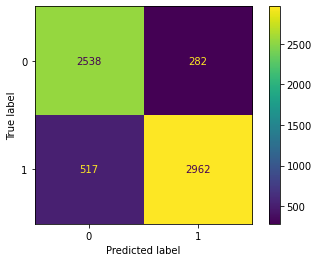

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, binary_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# 2. Random Forest 

In [7]:
# Extract features using a pre-trained model
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=base_model.output)


In [23]:
# Resize each image in X_train to (224, 224)
resized_images = []
for img_array in X_train:
    img = Image.fromarray(np.uint8(img_array))
    resized_img = img.resize((224, 224))
    resized_images.append(resized_img)

# Convert the list of resized images to a numpy array
resized_X_train = np.array([np.array(img) for img in resized_images])

# Extract features using MobileNetV2
train_features = feature_extractor.predict(resized_X_train)

# Flatten the features
num_samples, height, width, channels = train_features.shape
train_features_flattened = train_features.reshape((num_samples, height * width * channels))

# Create and train the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features_flattened, y_train)


946/946 ━━━━━━━━━━━━━━━━━━━━ 2308s 2s/step


RandomForestClassifier(random_state=42)

In [40]:
#Evaluate Random Forest Classifier on test data
resized_test_images = []
for img_array in X_test:
    img = Image.fromarray(np.uint8(img_array))
    resized_img = img.resize((224, 224))
    resized_test_images.append(resized_img)

# Convert the list of resized images to a numpy array
resized_X_test = np.array([np.array(img) for img in resized_test_images])

# Extract features using MobileNetV2
test_features = feature_extractor.predict(resized_X_test)

# Flatten the features
num_samples, height, width, channels = test_features.shape
test_features_flattened = test_features.reshape((num_samples, height * width * channels))

# Make predictions using the pre-trained MobileNetV2 model
predictions = rf_classifier.predict(test_features_flattened)


197/197 ━━━━━━━━━━━━━━━━━━━━ 588s 3s/step


In [42]:
threshold = 0.5  # Define a threshold to convert probabilities to binary labels
rf_binary_predictions = np.where(predictions >= threshold, 1, 0)

rf_accuracy = accuracy_score(y_test, rf_binary_predictions)

print("Accuracy:", rf_accuracy)

Accuracy: 0.8890300047626607


In [ ]:
f2 = metrics.fbeta_score(y_test, rf_binary_predictions, beta=1, average='binary')
f1 = metrics.fbeta_score(y_test, rf_binary_predictions, beta=2, average = 'binary')
print("f1: ", f1, "f2: ", f2)
print("precision: ", metrics.precision_score(y_test, rf_binary_predictions, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn'))
print("recall: ", metrics.recall_score(y_test, rf_binary_predictions, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn'))

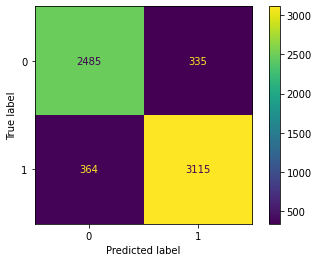

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, rf_binary_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# 3. KNN

In [44]:
# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# Train k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors= 3)
knn_classifier.fit(train_features_flattened, y_train)

# Evaluate the model
# 


KNeighborsClassifier(n_neighbors=3)

In [45]:
knn_predictions = knn_classifier.predict(test_features_flattened)

In [46]:
threshold = 0.5  # Define a threshold to convert probabilities to binary labels
knn_binary_predictions = np.where(knn_predictions >= threshold, 1, 0)

knn_accuracy = accuracy_score(y_test, knn_binary_predictions)

print("Accuracy:", knn_accuracy)

Accuracy: 0.8956977297983807


In [ ]:
f2 = metrics.fbeta_score(y_test, knn_binary_predictions, beta=1, average='binary')
f1 = metrics.fbeta_score(y_test, knn_binary_predictions, beta=2, average = 'binary')
print("f1: ", f1, "f2: ", f2)
print("precision: ", metrics.precision_score(y_test, knn_binary_predictions, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn'))
print("recall: ", metrics.recall_score(y_test, knn_binary_predictions, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn'))

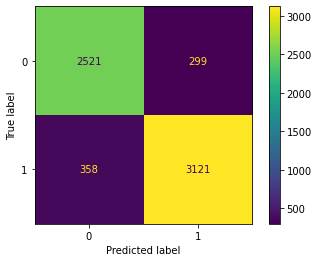

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, knn_binary_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()